# 기존 모델 구성

In [92]:
# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# statistics
import statsmodels.api as sm

import statsmodels.formula.api as smf

# pandas options
pd.set_option('mode.copy_on_write', True)  # pandas 2.0
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 7  # max number of rows to display

# NumPy options
np.set_printoptions(precision = 2, suppress=True)  # suppress scientific notation

# For high resolution display
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

In [93]:
# Build a rangeplot!
def rangeplot(df, x, y, color=None):
    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Range(), so.Est(errorbar=("pi", 50)), so.Dodge())
        .add(so.Dots(pointsize=8, marker="<"), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )

In [94]:
# import the data
flights = sm.datasets.get_rdataset('flights', 'nycflights13').data

# convert the date column to a datetime object
flights["time_hour"] = pd.to_datetime(flights["time_hour"])

# add a column for the day of the week
flights["dow"] = (
    flights["time_hour"]
    .dt.day_name()  # 요일 추출
    .str[:3]  # 요일 앞 3글자
    .astype("category")
    .cat.set_categories(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
)

# add a column for the season
flights["season"] = np.where(flights["month"].isin([6, 7]), "summer", "other month")

In [95]:
# filter out the flights to SFO
sfo = flights.query('dest == "SFO" & arr_delay < 500').copy()

In [96]:
sfo

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,dow,season
13,2013,1,1,558.00,600,-2.00,923.00,937,-14.00,UA,...,N53441,EWR,SFO,361.00,2565,6,0,2013-01-01 11:00:00+00:00,Tue,other month
26,2013,1,1,611.00,600,11.00,945.00,931,14.00,UA,...,N532UA,JFK,SFO,366.00,2586,6,0,2013-01-01 11:00:00+00:00,Tue,other month
55,2013,1,1,655.00,700,-5.00,1037.00,1045,-8.00,DL,...,N705TW,JFK,SFO,362.00,2586,7,0,2013-01-01 12:00:00+00:00,Tue,other month
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336679,2013,9,30,2001.00,2000,1.00,2302.00,2328,-26.00,UA,...,N35260,EWR,SFO,323.00,2565,20,0,2013-10-01 00:00:00+00:00,Tue,other month
336701,2013,9,30,2023.00,2025,-2.00,2315.00,2350,-35.00,B6,...,N712JB,JFK,SFO,327.00,2586,20,25,2013-10-01 00:00:00+00:00,Tue,other month
336762,2013,9,30,2233.00,2113,80.00,112.00,30,42.00,UA,...,N578UA,EWR,SFO,318.00,2565,21,13,2013-10-01 01:00:00+00:00,Tue,other month


In [97]:
mod = smf.ols("arr_delay ~ hour + origin + carrier + season + dow", data=sfo).fit()

In [98]:
# Parmeters
mod.params

Intercept       -20.44
origin[T.JFK]     4.16
carrier[T.B6]    -9.58
                 ...  
dow[T.Fri]       -4.95
dow[T.Sat]      -10.40
hour              2.07
Length: 14, dtype: float64

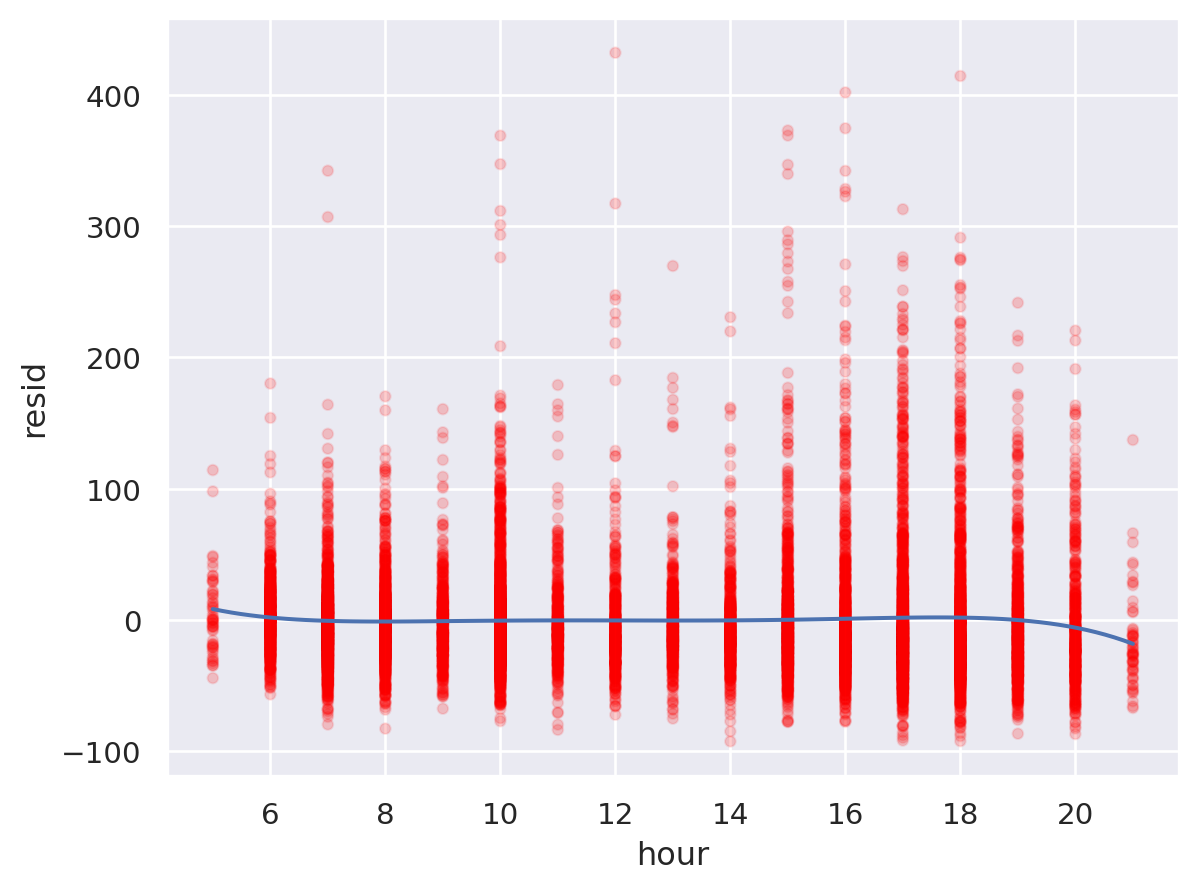

In [99]:
sfo["resid"] = mod.resid

(
    so.Plot(sfo, x='hour', y='resid')
    .add(so.Dots(alpha=.1, color = 'red'))
    .add(so.Line(), so.PolyFit(5))
)

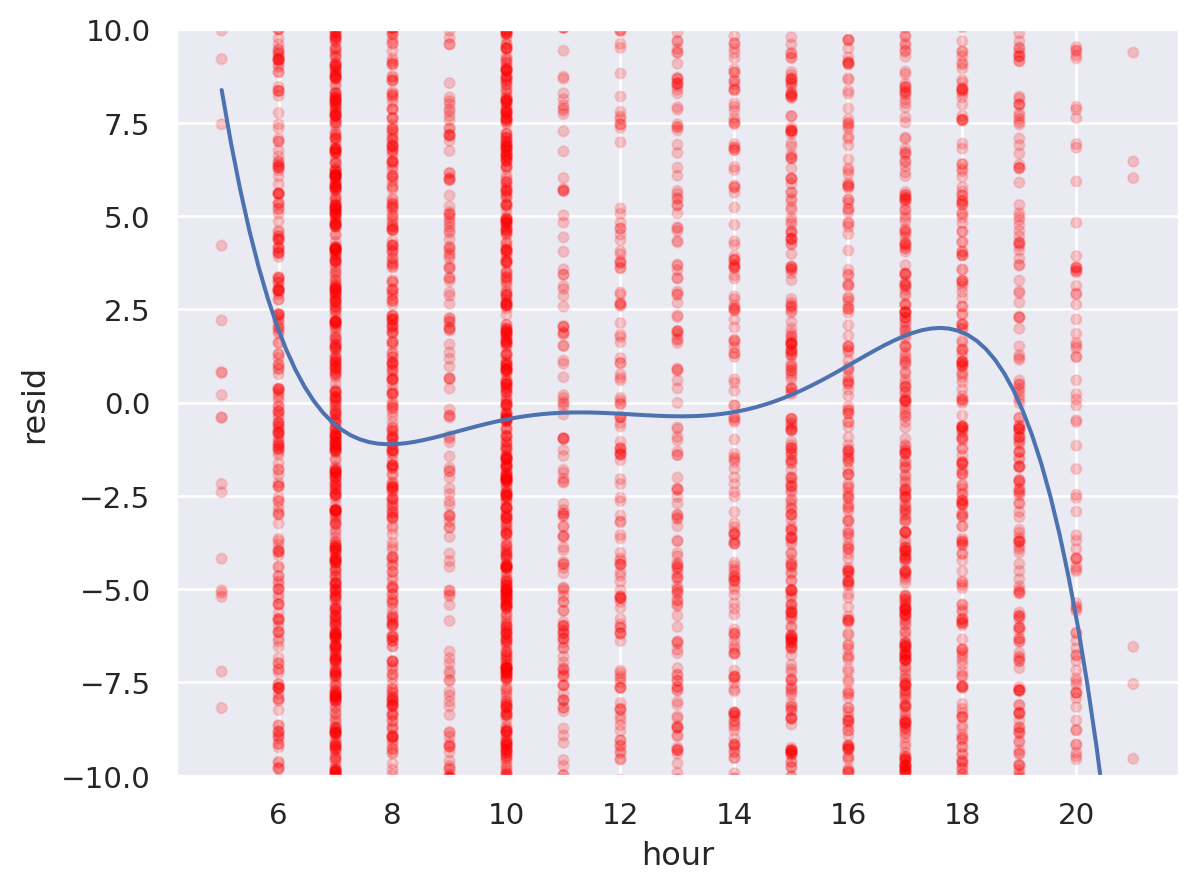

In [100]:
sfo["resid"] = mod.resid

(
    so.Plot(sfo, x='hour', y='resid')
    .add(so.Dots(alpha=.1, color = 'red'))
    .add(so.Line(), so.PolyFit(5))
    .limit(y=(-10, 10))
)

## 모델을 왜 이렇게 구성했는가?
### hour, origin, carrier, season, dow가 각 카테고리별로 arr_delay 값의 차이가 있는 것을 확인할 수 있음. 각 변수의 효과를 반영해주기 위해서 이를 포함해서 구성한 걸로 생각됨.

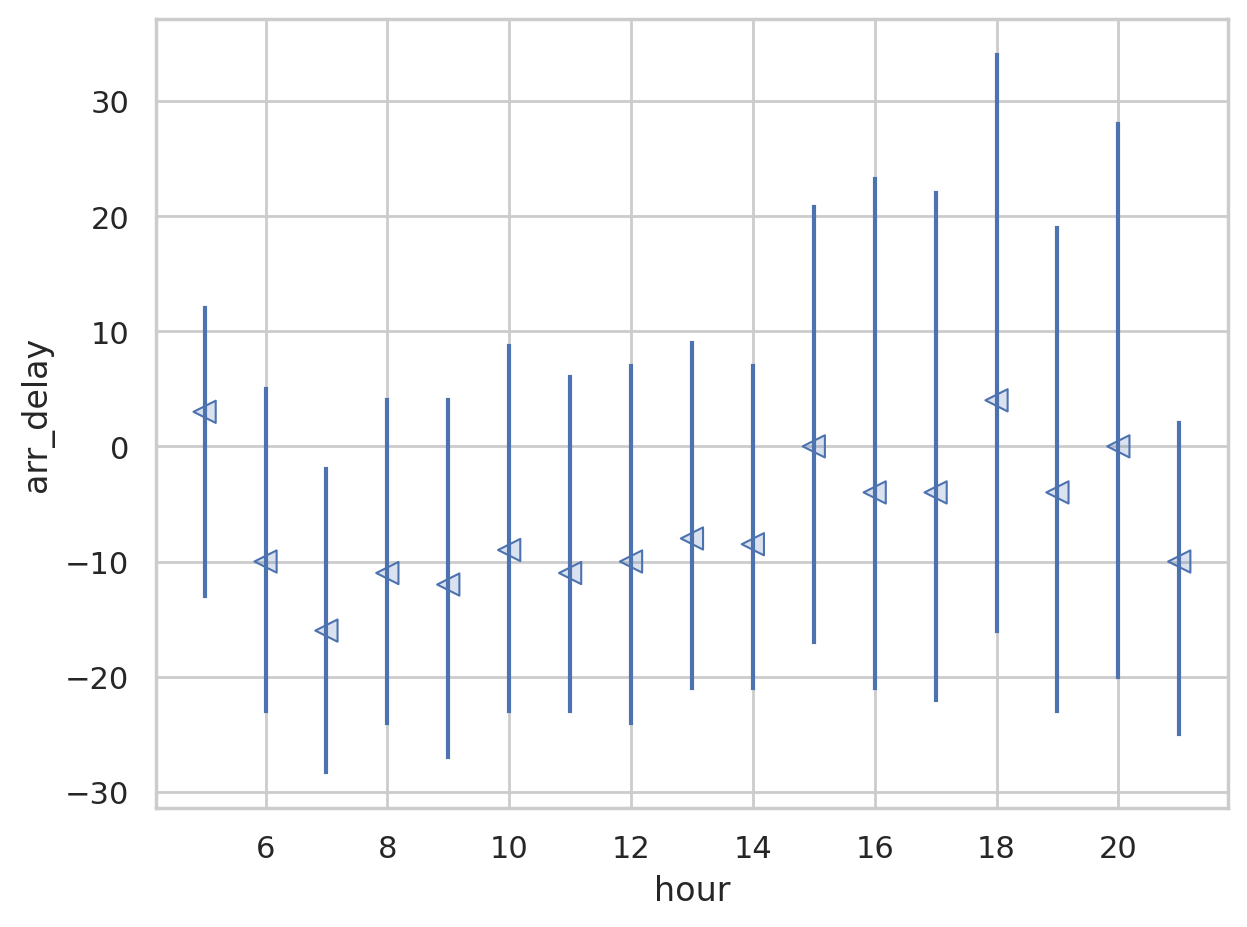

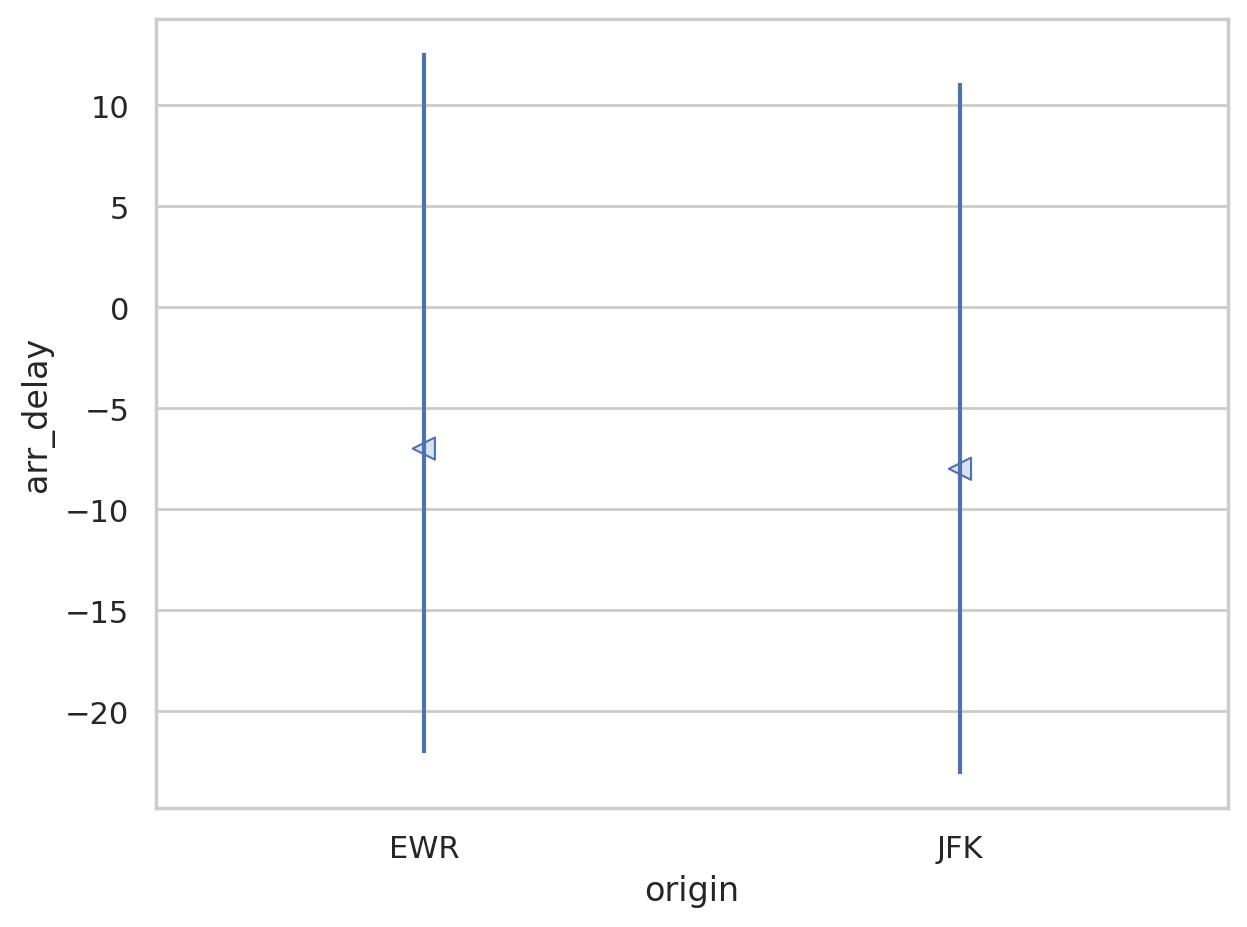

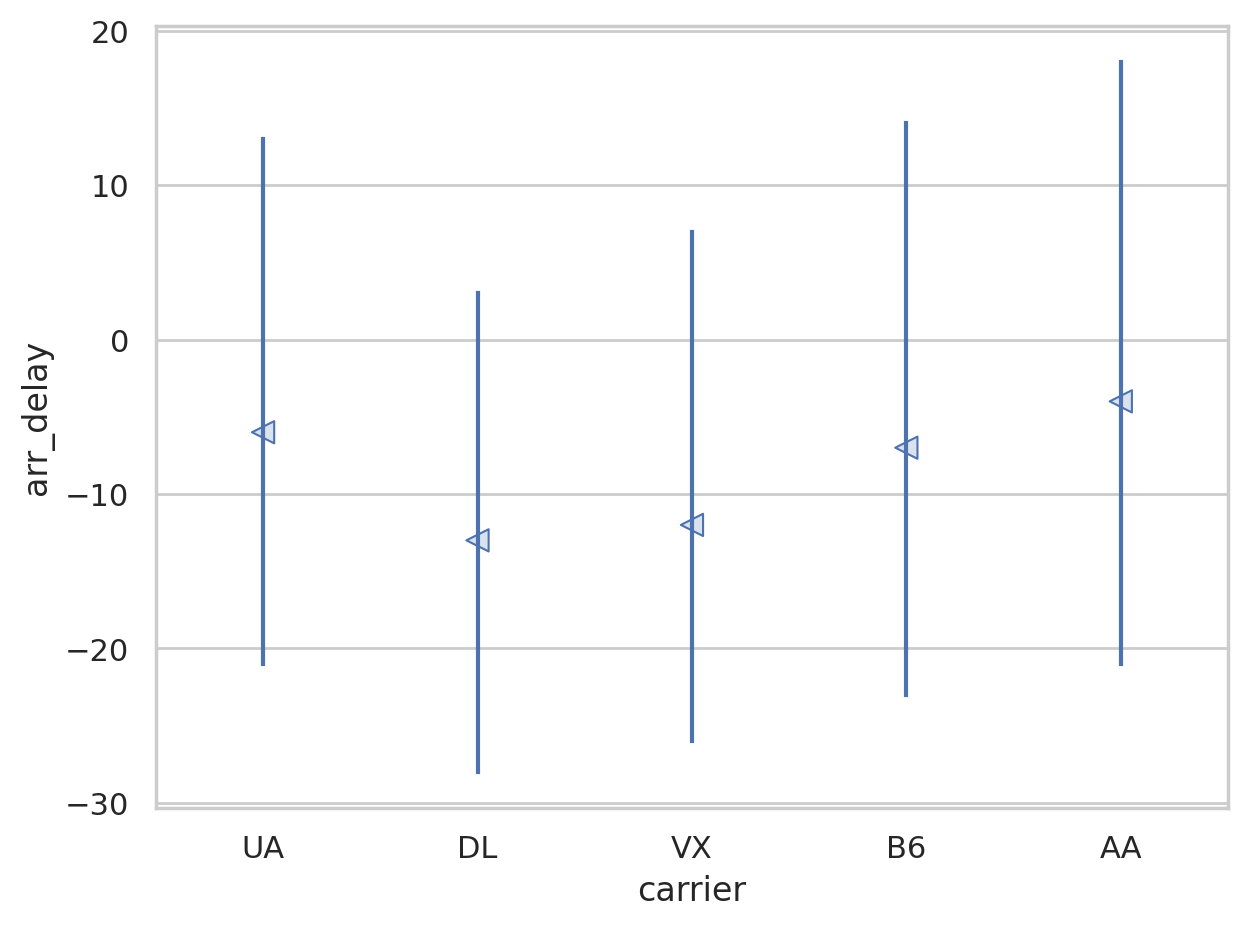

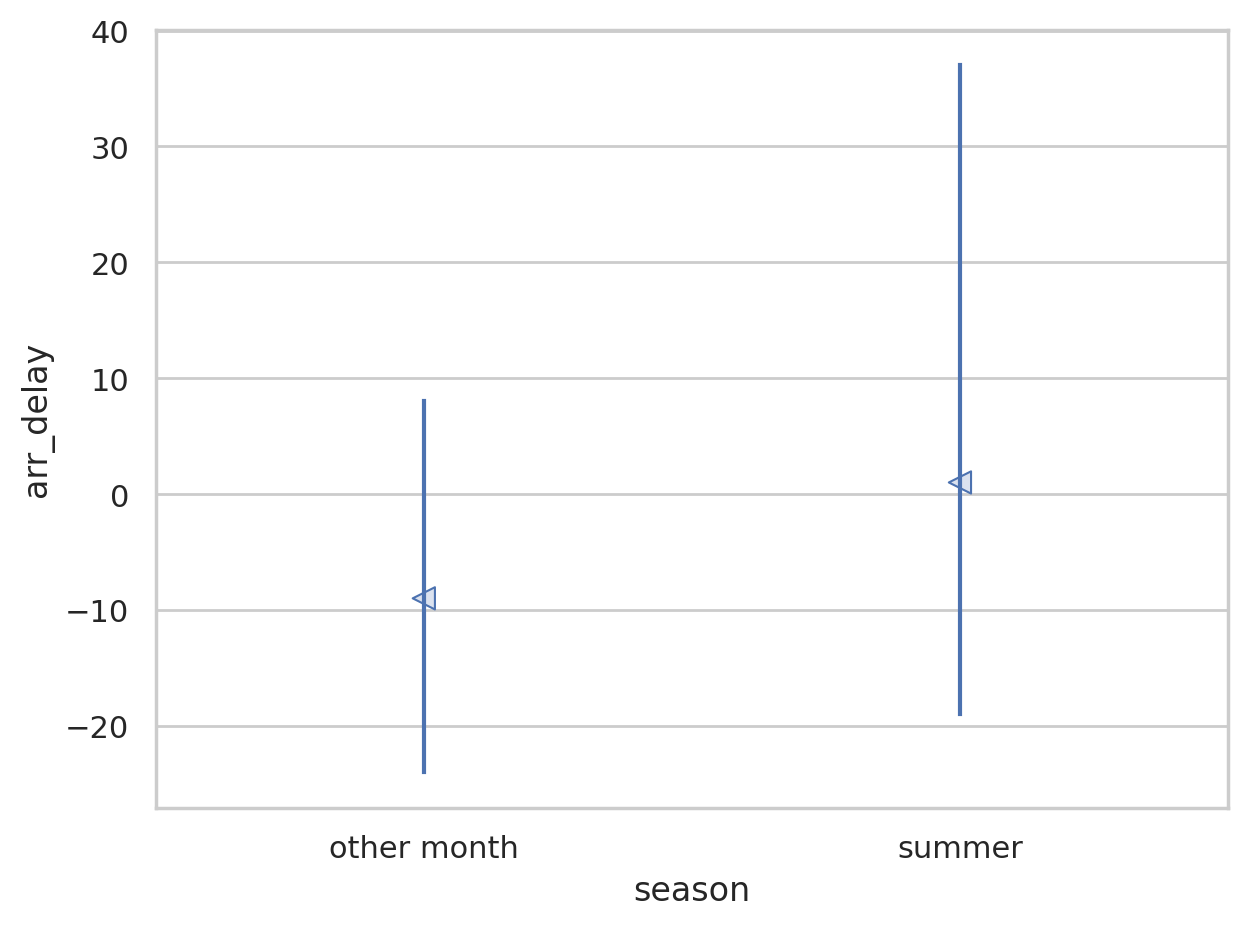

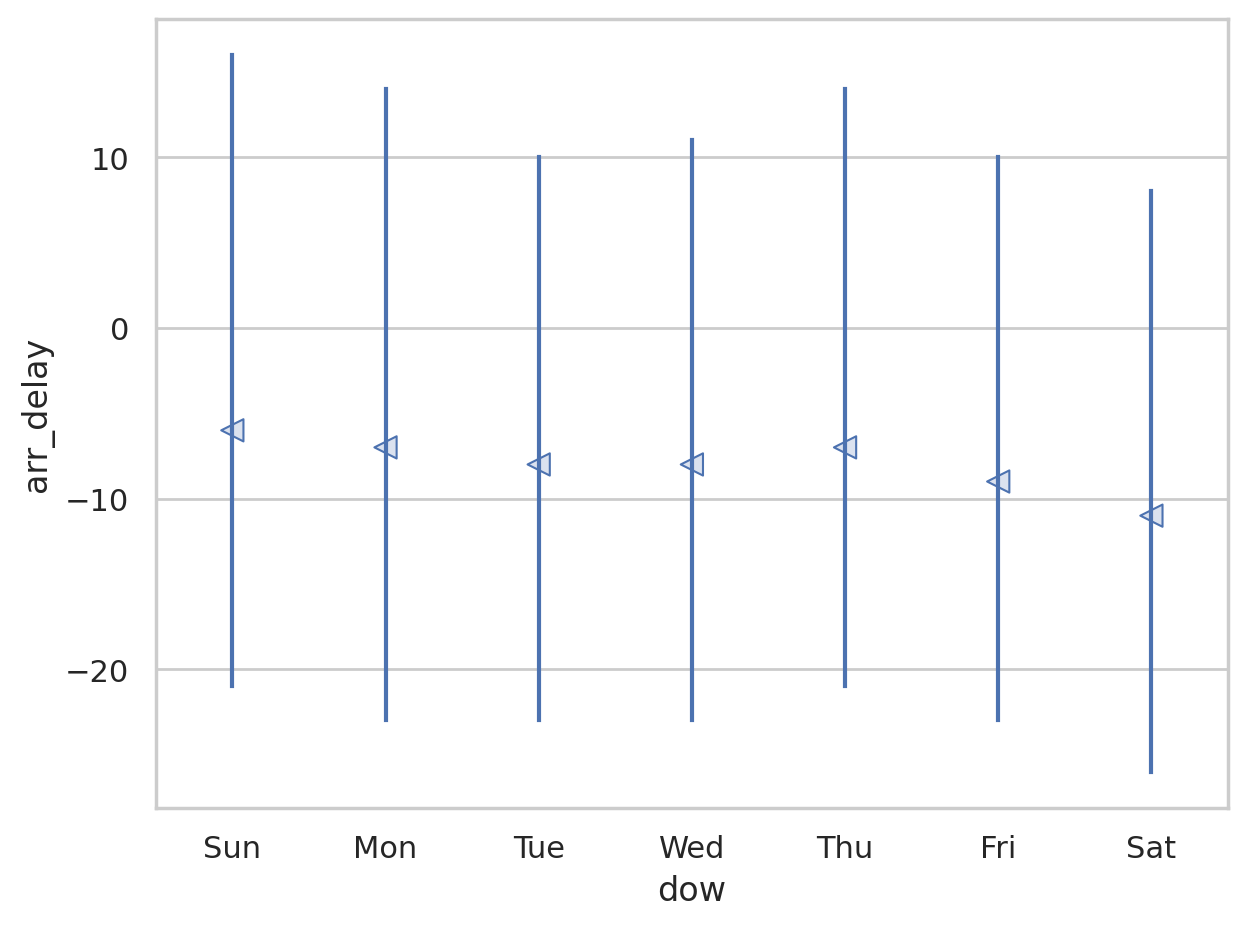

In [101]:
hour = rangeplot(sfo, x="hour", y="arr_delay").show()
origin = rangeplot(sfo, x="origin", y="arr_delay").show()
carrier = rangeplot(sfo, x="carrier", y="arr_delay").show()
season = rangeplot(sfo, x="season", y="arr_delay").show()
dow = rangeplot(sfo, x="dow", y="arr_delay").show()

In [102]:
from statsmodels.formula.api import ols

mod_hour = ols("arr_delay ~ hour", data=sfo).fit()
mod_hour.params

Intercept   -22.98
hour          2.00
dtype: float64

## 좋은 모델인가?
### 잔차가 패턴을 보이지는 않지만, 잔차가 오른쪽으로 치우쳐져 있으며, RMSE 값을 확인해본 결과, 크기 때문에 좋은 모델이 아니다.

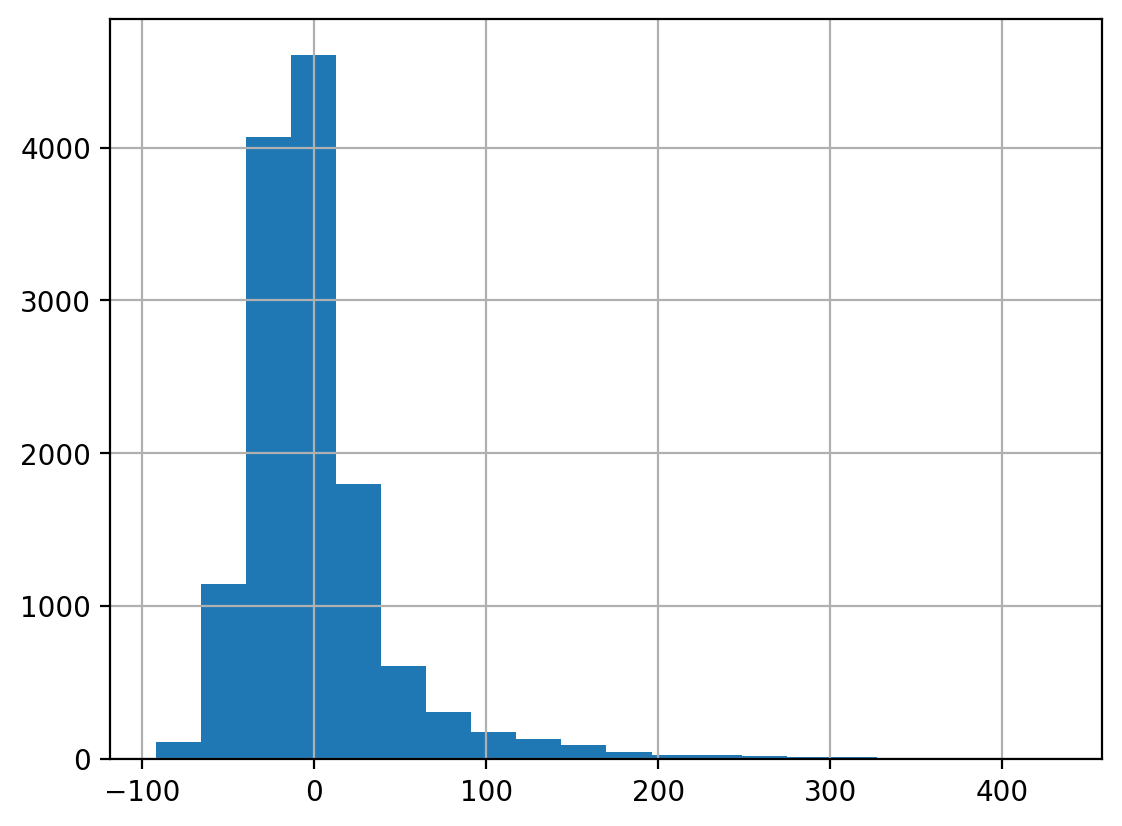

In [103]:
sfo["resid"].hist(bins=20)
plt.show()

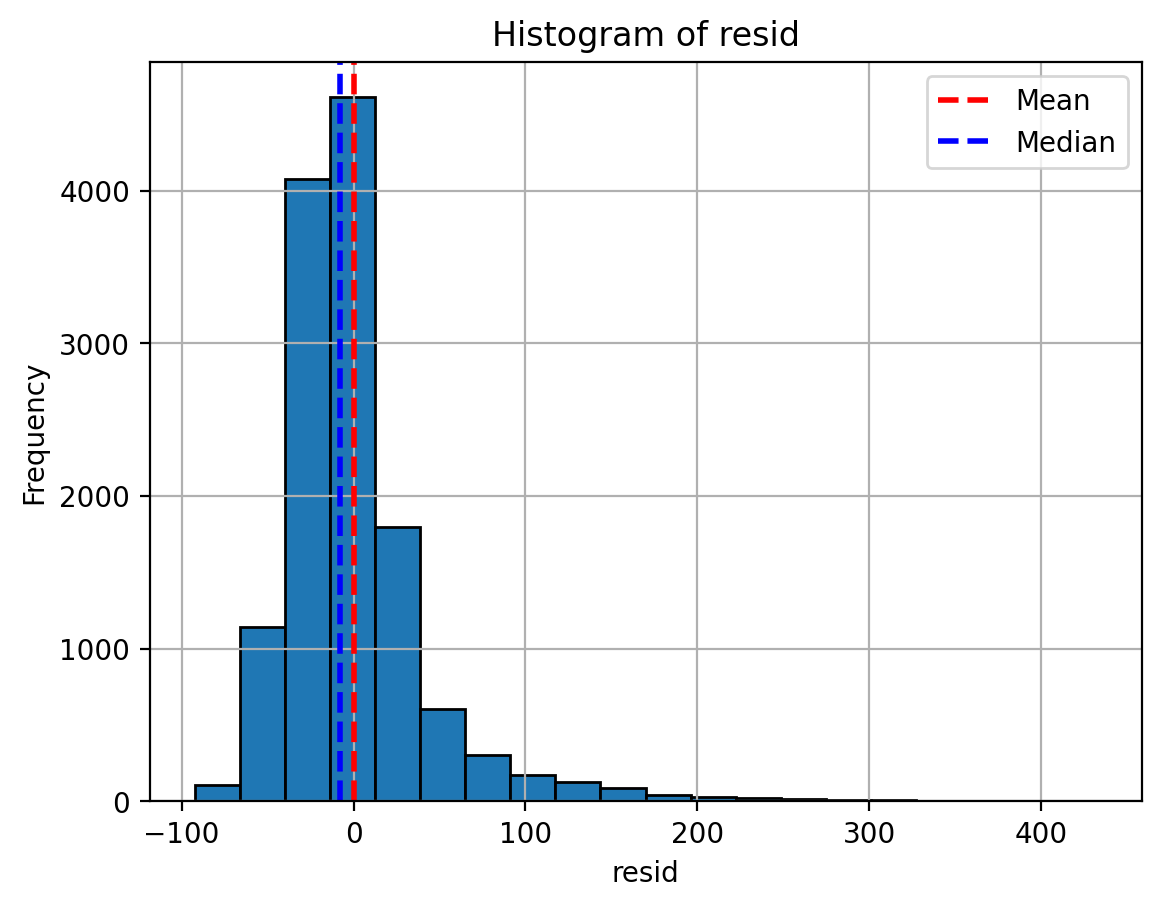

In [104]:
# 히스토그램 그리기
sfo["resid"].hist(bins=20, edgecolor='black')
plt.title('Histogram of resid')
plt.xlabel('resid')
plt.ylabel('Frequency')

# 평균과 중앙값 계산
mean_resid = sfo["resid"].mean()
median_resid = sfo["resid"].median()

# 평균과 중앙값 라인 추가
plt.axvline(mean_resid, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(median_resid, color='blue', linestyle='dashed', linewidth=2, label='Median')

# 범례 추가
plt.legend()

# 시각화 출력
plt.show()

In [105]:
mod.mse_resid

1908.6862658174605

# 새로운 모델 구성

## 추가 사항

### 1
#### month 6, 7, 12월이 arr_delay가 높아지는 것을 확인할 수 있음. 이를 고려해주기 위해 month 변수도 포함시키고자 함.

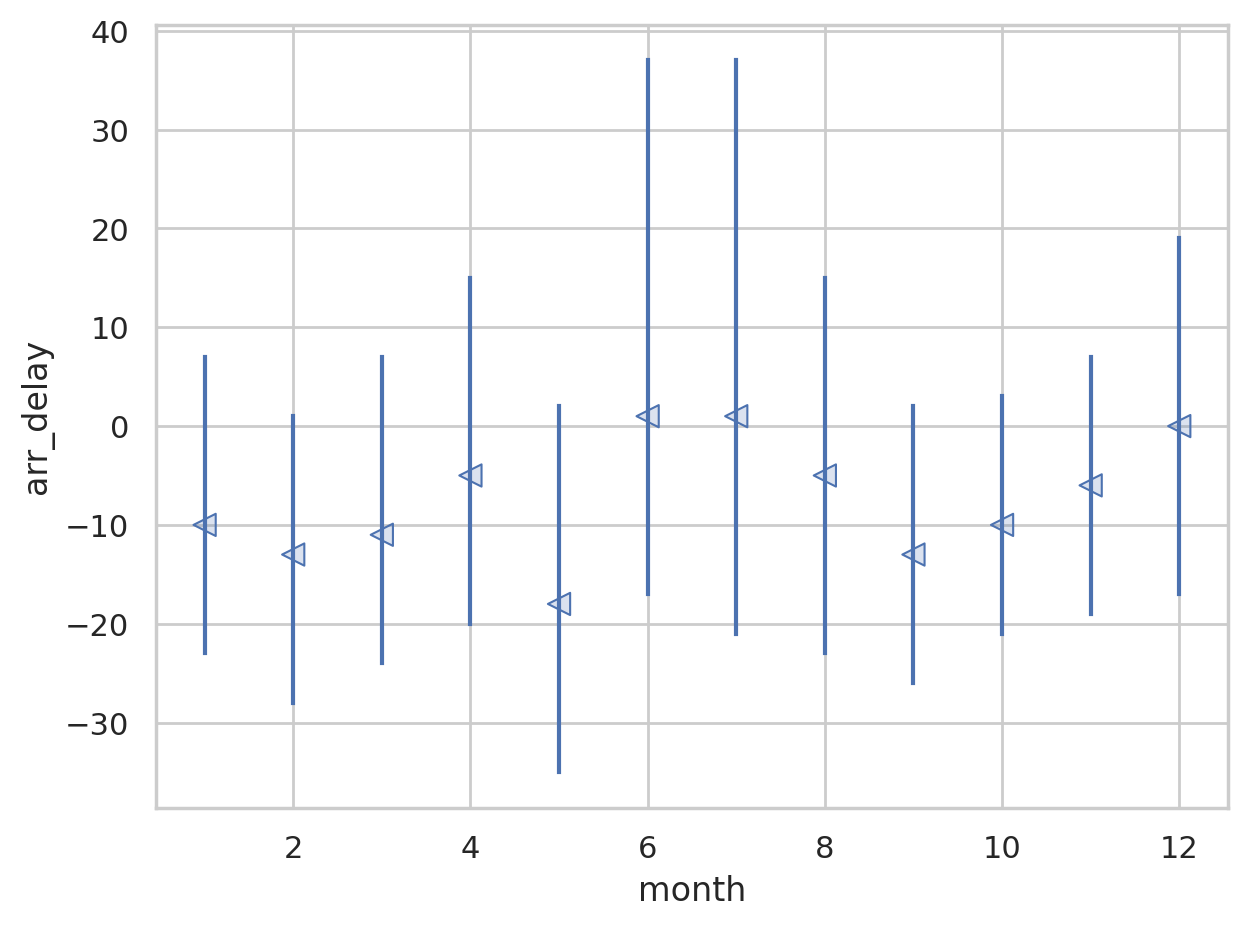

In [106]:
month = rangeplot(sfo, x="month", y="arr_delay").show()

In [107]:
from statsmodels.formula.api import ols

mod_month = ols("arr_delay ~ month", data=sfo).fit()
mod_month.params

Intercept   0.01
month       0.36
dtype: float64

### 2
#### dep_delay 변수 시각화한 결과, arr_delay에 대해서 선형적인 패턴을 가지고 있는 것을 파악함. 이를 고려해주기 위해 arr_delay 변수도 포함시키고자 함.

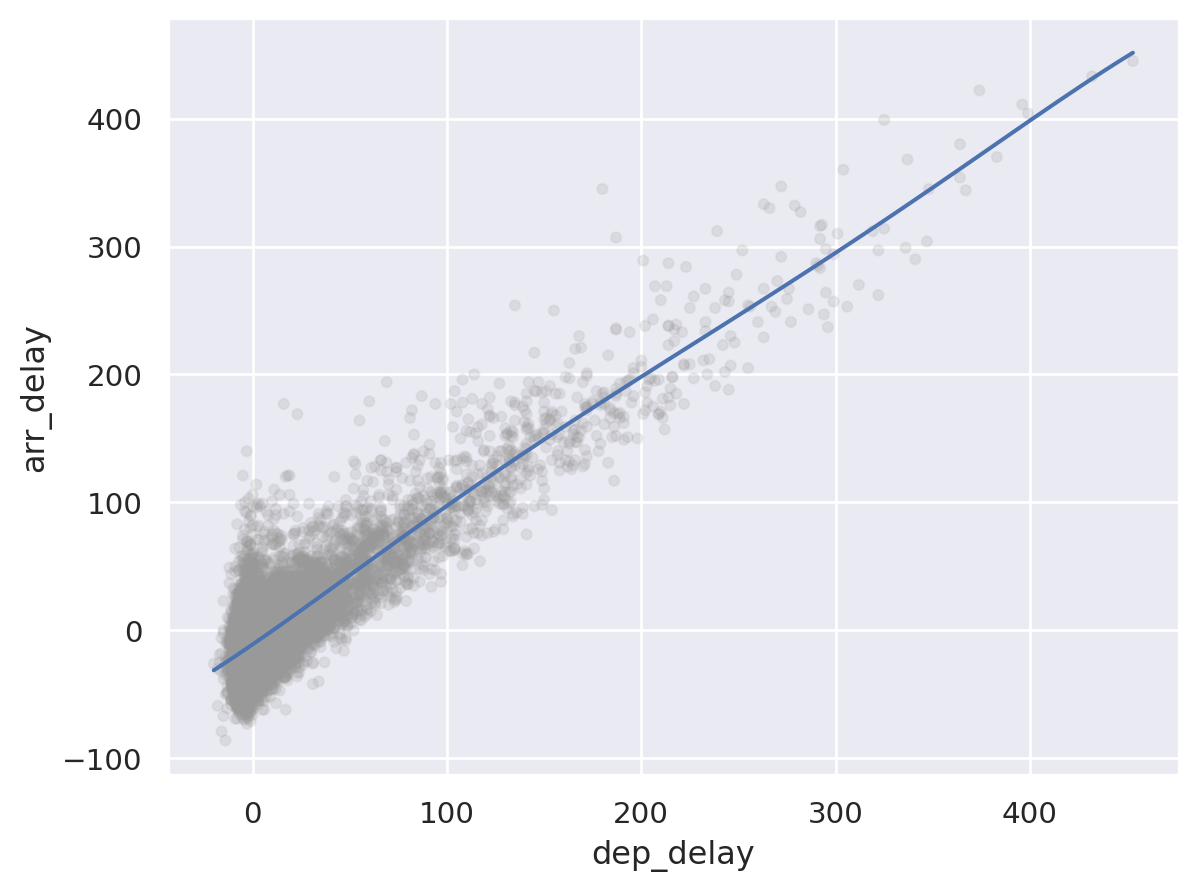

In [108]:
(
    so.Plot(sfo, x='dep_delay', y='arr_delay')
    .add(so.Dots(alpha=.1, color=".6"))
    .add(so.Line(), so.PolyFit(5))
)

### 3
#### air_time 변수 시각화한 결과, air_time이 길수록 arr_delay도 늘어나는 것을 확인함. 이를 고려해주기 위해 air_time 변수도 포함시키고자 함.

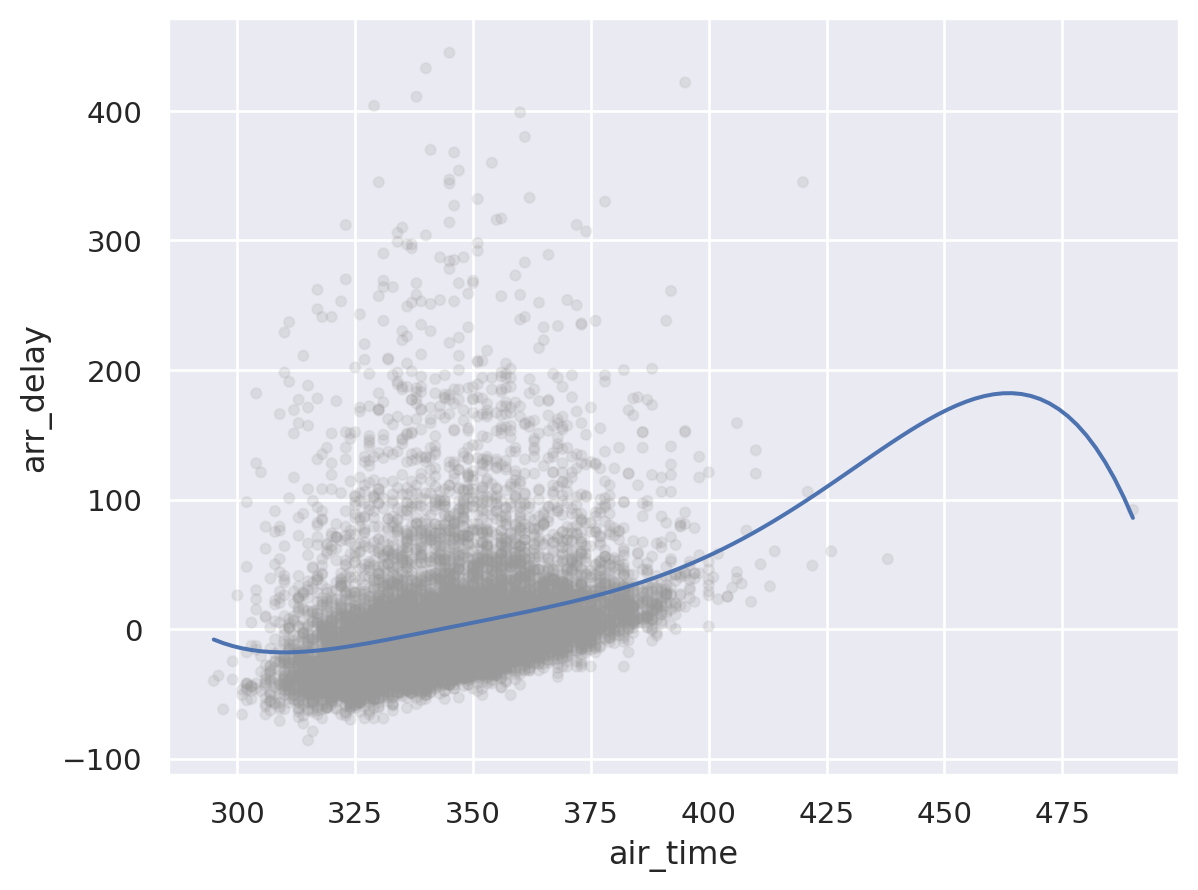

In [134]:
(
    so.Plot(sfo, x='air_time', y='arr_delay')
    .add(so.Dots(alpha=.1, color=".6"))
    .add(so.Line(), so.PolyFit(5))
)

## 모델 구현

In [145]:
mod_2 = smf.ols("arr_delay ~ hour + carrier + season + dow + dep_delay + air_time", data=sfo).fit()

In [146]:
mod_2.params

Intercept       -317.31
carrier[T.B6]     -2.93
carrier[T.DL]     -4.60
                  ...  
hour               0.04
dep_delay          1.04
air_time           0.88
Length: 15, dtype: float64

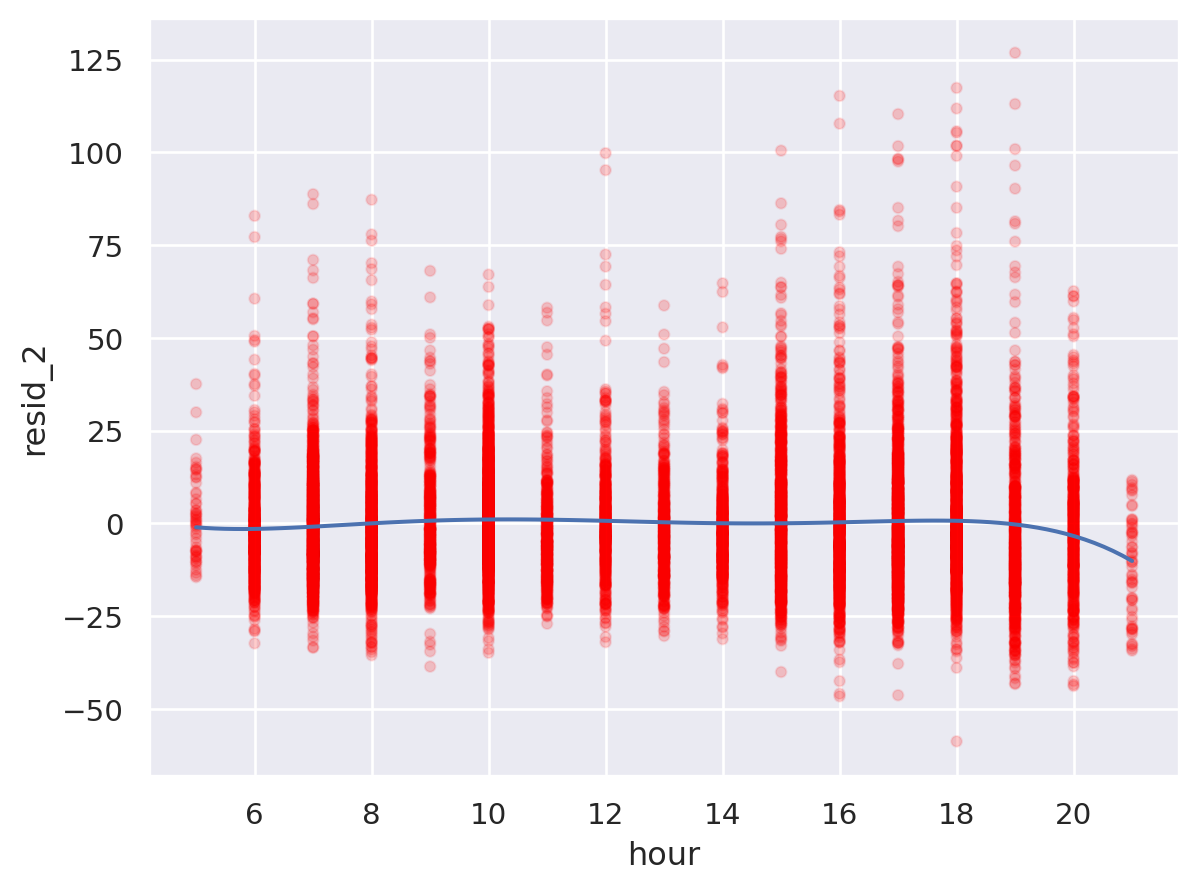

In [147]:
sfo["resid_2"] = mod_2.resid

(
    so.Plot(sfo, x='hour', y='resid_2')
    .add(so.Dots(alpha=.1, color = 'red'))
    .add(so.Line(), so.PolyFit(5))
)

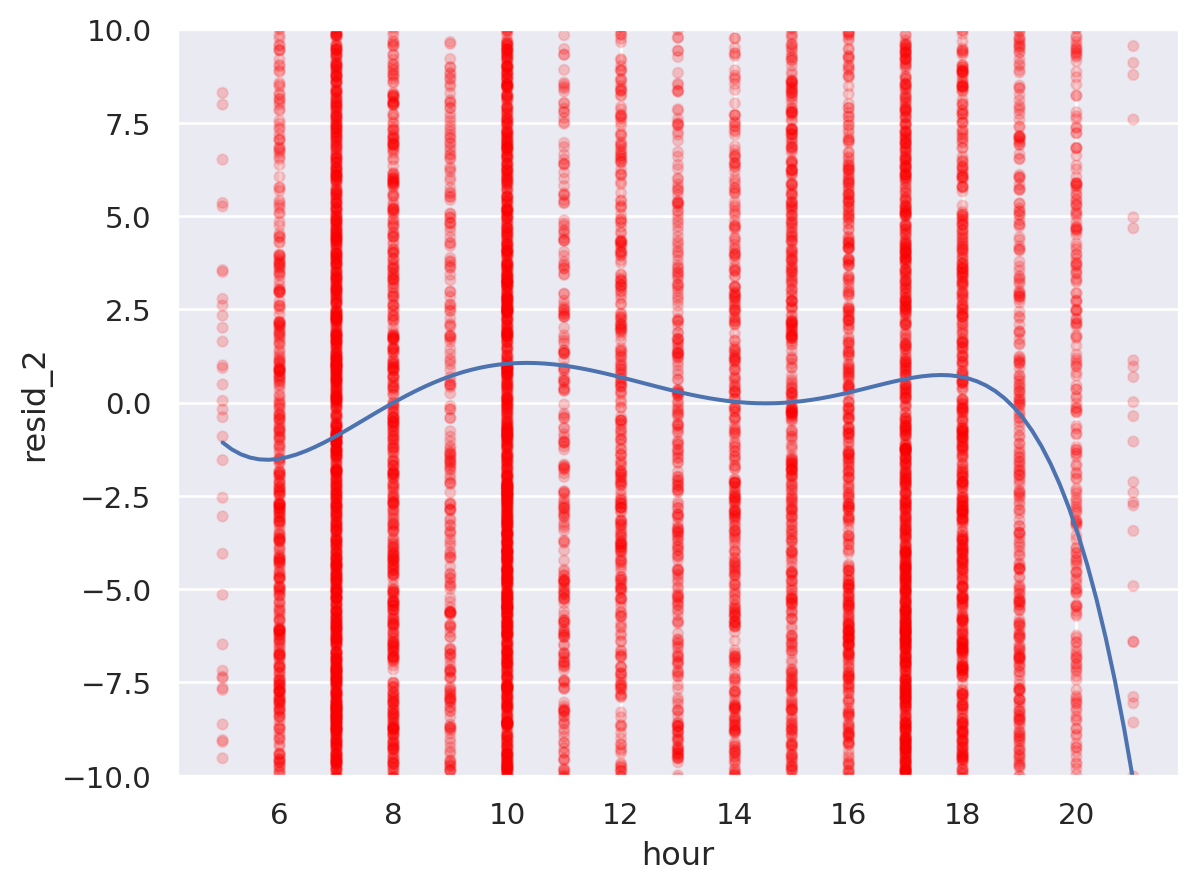

In [148]:
(
    so.Plot(sfo, x='hour', y='resid_2')
    .add(so.Dots(alpha=.1, color = 'red'))
    .add(so.Line(), so.PolyFit(5))
    .limit(y=(-10, 10))
)

## 좋은 모델인가?
### 잔차 분포가 전보다 더 이상적이며, 잔차의 패턴이 따로 존재하지 않는다. 또한 RMSE 값 또한 기존 값이 1908이었던 반면에, 265로 개선되는 것을 확인할 수 있다.

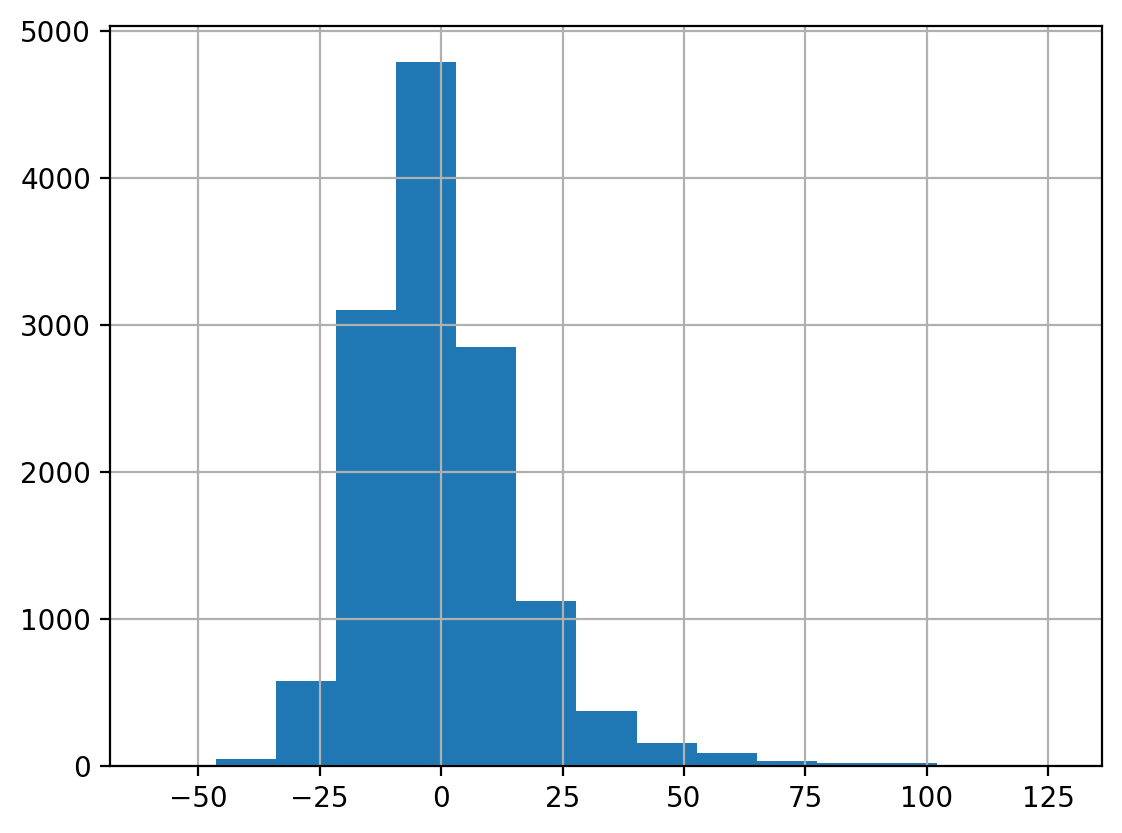

In [149]:
sfo["resid_2"].hist(bins=15)
plt.show()

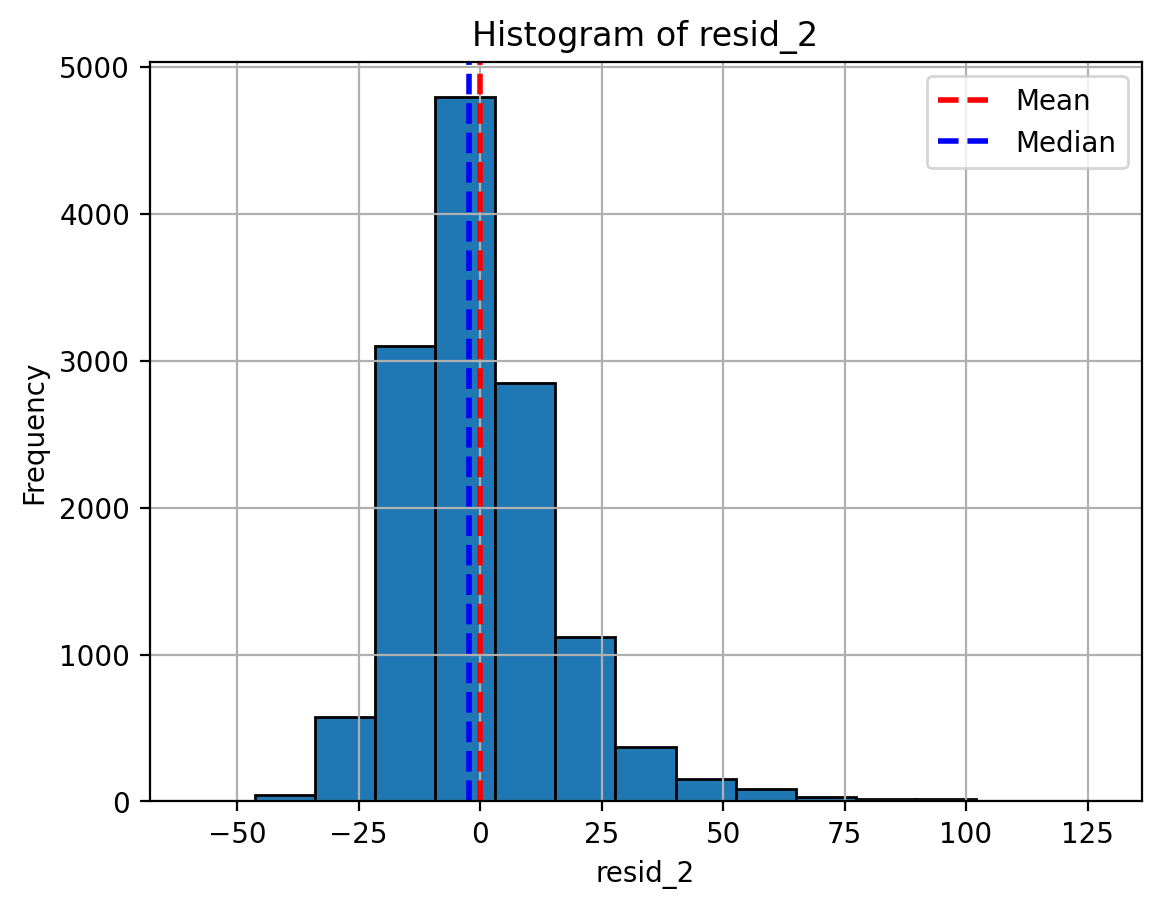

In [150]:
# 히스토그램 그리기
sfo["resid_2"].hist(bins=15, edgecolor='black')
plt.title('Histogram of resid_2')
plt.xlabel('resid_2')
plt.ylabel('Frequency')

# 평균과 중앙값 계산
mean_resid = sfo["resid_2"].mean()
median_resid = sfo["resid_2"].median()

# 평균과 중앙값 라인 추가
plt.axvline(mean_resid, color='red', linestyle='dashed', linewidth=2, label='Mean')
plt.axvline(median_resid, color='blue', linestyle='dashed', linewidth=2, label='Median')

# 범례 추가
plt.legend()

# 시각화 출력
plt.show()

In [151]:
mod_2.mse_resid

267.310278738521